In [2]:
!pip install inference-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.11.0.86
    Uninstalling opencv-python-4.11.0.86:
      Successfully uninstalled opencv-python-4.11.0.86
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15


In [3]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="D3Xlf1qhYUAr4LQ84DbN"
)

result = CLIENT.infer('/content/download.png', model_id="football-players-detection-3zvbc/11")



In [4]:
import cv2
import supervision as sv
image = cv2.imread('/content/download.png')
detections = sv.Detections.from_inference(result)

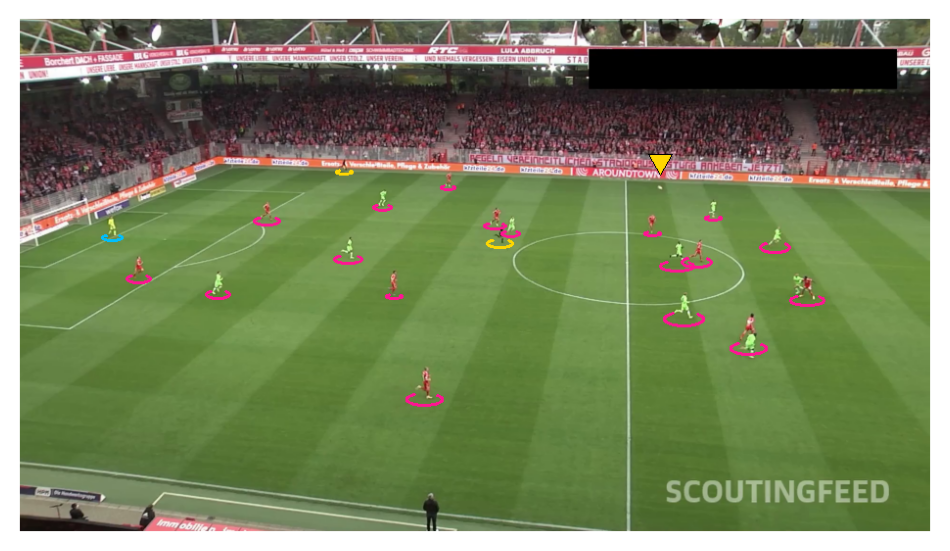

In [6]:
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
tracker = sv.ByteTrack()
tracker.reset()


ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)
labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]


annotated_frame = image.copy()

annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)

annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)


sv.plot_image(annotated_frame)

In [7]:
!pip install tqdm

In [9]:
from tqdm import tqdm
PLAYER_ID = 2
crops =[]
for frame in tqdm(image, desc='collecting crops'):
    result = result.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops:   0%|          | 0/543 [00:00<?, ?it/s]


AttributeError: 'dict' object has no attribute 'infer'

In [ ]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [13]:
!gdown -O "best.pt" "https://drive.google.com/file/d/1DC2kCygbBWUKheQ_9cFziCsYVSRw6axK/view?usp=sharing"
#!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"


/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1DC2kCygbBWUKheQ_9cFziCsYVSRw6axK
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1DC2kCygbBWUKheQ_9cFziCsYVSRw6axK/view?usp=sharing
To: /content/best.pt
37.4kB [00:00, 33.1MB/s]


In [12]:
from inference_sdk import InferenceHTTPClient
import cv2
import supervision as sv
import os
import time

# Initialize Roboflow client
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="D3Xlf1qhYUAr4LQ84DbN"
)

# Set up annotators and tracker
BALL_ID = 0
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
tracker = sv.ByteTrack()

# Input/output paths
video_path = "/content/0bfacc_0.mp4"
output_path = "/content/output.mp4"

# OpenCV video setup
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

frame_count = 0
tracker.reset()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Save temp frame for inference
    temp_path = "/content/temp_frame.png"
    cv2.imwrite(temp_path, frame)

    # Inference
    result = CLIENT.infer(temp_path, model_id="football-players-detection-3zvbc/11")
    detections = sv.Detections.from_inference(result)

    # Ball & player separation
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections.class_id -= 1
    all_detections = tracker.update_with_detections(detections=all_detections)

    # Annotation
    annotated = frame.copy()
    annotated = ellipse_annotator.annotate(scene=annotated, detections=all_detections)
    annotated = triangle_annotator.annotate(scene=annotated, detections=ball_detections)
    out.write(annotated)

    frame_count += 1
    print(f"Processed frame {frame_count}")
    time.sleep(1)

cap.release()
out.release()
os.remove(temp_path)
print(f"Saved annotated video to: {output_path}")


Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Processed frame 53
Pr

In [15]:
!git clone https://github.com/roboflow/sports.git
!pip install umap-learn scikit-learn torch torchvision

import sys
sys.path.append('/content/sports')

from sports.common.team import TeamClassifier


Cloning into 'sports'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 190 (delta 29), reused 24 (delta 24), pack-reused 150 (from 1)
Receiving objects: 100% (190/190), 3.09 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (88/88), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [17]:
from inference_sdk import InferenceHTTPClient
import cv2
import supervision as sv
from sports.common.team import TeamClassifier
import os
import time
import numpy as np
from tqdm import tqdm

# --- Constants ---
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30

# --- Roboflow API Client ---
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="D3Xlf1qhYUAr4LQ84DbN"
)

# --- Video Setup ---
video_path = "/content/0bfacc_0.mp4"
output_path = "/content/output1.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

# --- Annotators & Tracker ---
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
tracker = sv.ByteTrack()
tracker.reset()

# --- Step 1: Collect Player Crops ---
frame_generator = sv.get_video_frames_generator(video_path, stride=STRIDE)
crops = []

print("Collecting player crops for team classification...")
for frame in tqdm(frame_generator, desc="Collecting crops"):
    result = CLIENT.infer(frame, model_id="football-players-detection-3zvbc/11")
    detections = sv.Detections.from_inference(result)
    players = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players.xyxy]
    crops += players_crops

# --- Step 2: Train Team Classifier ---
team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

# --- Step 3: Process Video Frame-by-Frame ---
frame_count = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

def resolve_goalkeepers_team_id(players, goalkeepers):
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    result = []
    for gk_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(gk_xy - team_0_centroid)
        dist_1 = np.linalg.norm(gk_xy - team_1_centroid)
        result.append(0 if dist_0 < dist_1 else 1)
    return np.array(result)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    temp_path = "/content/temp_frame.png"
    cv2.imwrite(temp_path, frame)

    result = CLIENT.infer(temp_path, model_id="football-players-detection-3zvbc/11")
    detections = sv.Detections.from_inference(result)

    # Ball
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # All other
    others = detections[detections.class_id != BALL_ID]
    others = others.with_nms(threshold=0.5, class_agnostic=True)
    others = tracker.update_with_detections(detections=others)

    # Split by role
    goalkeepers = others[others.class_id == GOALKEEPER_ID]
    players = others[others.class_id == PLAYER_ID]
    referees = others[others.class_id == REFEREE_ID]

    # Predict teams for players
    player_crops = [sv.crop_image(frame, xyxy) for xyxy in players.xyxy]
    players.class_id = team_classifier.predict(player_crops)

    # Assign team to goalkeepers
    goalkeepers.class_id = resolve_goalkeepers_team_id(players, goalkeepers)

    # Mark referees with neutral class (e.g., -1 -> 2 for yellow)
    referees.class_id = np.full_like(referees.class_id, 2)

    # Merge all
    all_detections = sv.Detections.merge([players, goalkeepers, referees])
    labels = [f"#{id}" for id in all_detections.tracker_id]
    all_detections.class_id = all_detections.class_id.astype(int)

    # Annotate
    annotated = frame.copy()
    annotated = ellipse_annotator.annotate(scene=annotated, detections=all_detections)
    annotated = label_annotator.annotate(scene=annotated, detections=all_detections, labels=labels)
    annotated = triangle_annotator.annotate(scene=annotated, detections=ball_detections)

    out.write(annotated)
    frame_count += 1
    print(f"Processed frame {frame_count}")
    time.sleep(1)

cap.release()
out.release()
os.remove(temp_path)
print(f"Saved annotated video to: {output_path}")


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Embedding extraction: 16it [06:40, 25.01s/it]
Embedding extraction: 1it [00:16, 16.48s/it]


Processed frame 1


Embedding extraction: 1it [00:17, 17.69s/it]


Processed frame 2


Embedding extraction: 1it [00:15, 15.74s/it]


Processed frame 3


Embedding extraction: 1it [00:15, 15.53s/it]


Processed frame 4


Embedding extraction: 1it [00:15, 15.90s/it]


Processed frame 5


Embedding extraction: 1it [00:15, 15.55s/it]


Processed frame 6


Embedding extraction: 1it [00:14, 14.95s/it]


Processed frame 7


Embedding extraction: 1it [00:14, 14.69s/it]


Processed frame 8


Embedding extraction: 1it [00:14, 14.08s/it]


Processed frame 9


Embedding extraction: 1it [00:14, 14.05s/it]


Processed frame 10


Embedding extraction: 1it [00:13, 13.87s/it]


Processed frame 11


Embedding extraction: 1it [00:14, 14.62s/it]


Processed frame 12


Embedding extraction: 1it [00:14, 14.20s/it]


Processed frame 13


Embedding extraction: 1it [00:14, 14.21s/it]


Processed frame 14


Embedding extraction: 1it [00:14, 14.88s/it]


Processed frame 15


Embedding extraction: 1it [00:14, 14.27s/it]


Processed frame 16


Embedding extraction: 1it [00:13, 13.36s/it]


Processed frame 17


Embedding extraction: 1it [00:15, 15.57s/it]


Processed frame 18


Embedding extraction: 1it [00:15, 15.86s/it]


Processed frame 19


Embedding extraction: 1it [00:15, 15.55s/it]


Processed frame 20


Embedding extraction: 1it [00:15, 15.75s/it]


Processed frame 21


Embedding extraction: 1it [00:16, 16.16s/it]


Processed frame 22


Embedding extraction: 1it [00:15, 15.56s/it]


Processed frame 23


Embedding extraction: 1it [00:15, 15.97s/it]


Processed frame 24


Embedding extraction: 1it [00:21, 21.28s/it]


Processed frame 25


Embedding extraction: 1it [00:15, 15.61s/it]


Processed frame 26


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 27


Embedding extraction: 1it [00:15, 15.37s/it]


Processed frame 28


Embedding extraction: 1it [00:16, 16.51s/it]


Processed frame 29


Embedding extraction: 1it [00:15, 15.53s/it]


Processed frame 30


Embedding extraction: 1it [00:15, 15.40s/it]


Processed frame 31


Embedding extraction: 1it [00:15, 15.47s/it]


Processed frame 32


Embedding extraction: 1it [00:16, 16.72s/it]


Processed frame 33


Embedding extraction: 1it [00:16, 16.44s/it]


Processed frame 34


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 35


Embedding extraction: 1it [00:15, 15.52s/it]


Processed frame 36


Embedding extraction: 1it [00:15, 15.77s/it]


Processed frame 37


Embedding extraction: 1it [00:15, 15.57s/it]


Processed frame 38


Embedding extraction: 1it [00:16, 16.34s/it]


Processed frame 39


Embedding extraction: 1it [00:15, 15.69s/it]


Processed frame 40


Embedding extraction: 1it [00:15, 15.45s/it]


Processed frame 41


Embedding extraction: 1it [00:16, 16.33s/it]


Processed frame 42


Embedding extraction: 1it [00:15, 15.46s/it]


Processed frame 43


Embedding extraction: 1it [00:15, 15.55s/it]


Processed frame 44


Embedding extraction: 1it [00:15, 15.79s/it]


Processed frame 45


Embedding extraction: 1it [00:15, 15.63s/it]


Processed frame 46


Embedding extraction: 1it [00:15, 15.67s/it]


Processed frame 47


Embedding extraction: 1it [00:16, 16.64s/it]


Processed frame 48


Embedding extraction: 1it [00:15, 15.27s/it]


Processed frame 49


Embedding extraction: 1it [00:16, 16.44s/it]


Processed frame 50


Embedding extraction: 1it [00:15, 15.52s/it]


Processed frame 51


Embedding extraction: 1it [00:14, 14.77s/it]


Processed frame 52


Embedding extraction: 1it [00:15, 15.58s/it]


Processed frame 53


Embedding extraction: 1it [00:14, 14.84s/it]


Processed frame 54


Embedding extraction: 1it [00:15, 15.08s/it]


Processed frame 55


Embedding extraction: 1it [00:15, 15.76s/it]


Processed frame 56


Embedding extraction: 1it [00:15, 15.53s/it]


Processed frame 57


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 58


Embedding extraction: 1it [00:21, 21.64s/it]


Processed frame 59


Embedding extraction: 1it [00:15, 15.59s/it]


Processed frame 60


Embedding extraction: 1it [00:15, 15.06s/it]


Processed frame 61


Embedding extraction: 1it [00:15, 15.38s/it]


Processed frame 62


Embedding extraction: 1it [00:16, 16.80s/it]


Processed frame 63


Embedding extraction: 1it [00:15, 15.52s/it]


Processed frame 64


Embedding extraction: 1it [00:15, 15.66s/it]


Processed frame 65


Embedding extraction: 1it [00:15, 15.58s/it]


Processed frame 66


Embedding extraction: 1it [00:15, 15.79s/it]


Processed frame 67


Embedding extraction: 1it [00:15, 15.62s/it]


Processed frame 68


Embedding extraction: 1it [00:15, 15.99s/it]


Processed frame 69


Embedding extraction: 1it [00:14, 14.93s/it]


Processed frame 70


Embedding extraction: 1it [00:15, 15.13s/it]


Processed frame 71


Embedding extraction: 1it [00:15, 15.05s/it]


Processed frame 72


Embedding extraction: 1it [00:15, 15.03s/it]


Processed frame 73


Embedding extraction: 1it [00:15, 15.11s/it]


Processed frame 74


Embedding extraction: 1it [00:14, 14.91s/it]


Processed frame 75


Embedding extraction: 1it [00:14, 14.80s/it]


Processed frame 76


Embedding extraction: 1it [00:14, 14.91s/it]


Processed frame 77


Embedding extraction: 1it [00:15, 15.05s/it]


Processed frame 78


Embedding extraction: 1it [00:15, 15.13s/it]


Processed frame 79


Embedding extraction: 1it [00:15, 15.57s/it]


Processed frame 80


Embedding extraction: 1it [00:15, 15.67s/it]


Processed frame 81


Embedding extraction: 1it [00:15, 15.79s/it]


Processed frame 82


Embedding extraction: 1it [00:15, 15.83s/it]


Processed frame 83


Embedding extraction: 1it [00:16, 16.34s/it]


Processed frame 84


Embedding extraction: 1it [00:15, 15.66s/it]


Processed frame 85


Embedding extraction: 1it [00:16, 16.49s/it]


Processed frame 86


Embedding extraction: 1it [00:16, 16.31s/it]


Processed frame 87


Embedding extraction: 1it [00:15, 15.57s/it]


Processed frame 88


Embedding extraction: 1it [00:16, 16.43s/it]


Processed frame 89


Embedding extraction: 1it [00:15, 15.82s/it]


Processed frame 90


Embedding extraction: 1it [00:15, 15.64s/it]


Processed frame 91


Embedding extraction: 1it [00:16, 16.25s/it]


Processed frame 92


Embedding extraction: 1it [00:19, 19.93s/it]


Processed frame 93


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 94


Embedding extraction: 1it [00:15, 15.81s/it]


Processed frame 95


Embedding extraction: 1it [00:15, 15.67s/it]


Processed frame 96


Embedding extraction: 1it [00:15, 15.62s/it]


Processed frame 97


Embedding extraction: 1it [00:15, 15.87s/it]


Processed frame 98


Embedding extraction: 1it [00:15, 15.53s/it]


Processed frame 99


Embedding extraction: 1it [00:16, 16.62s/it]


Processed frame 100


Embedding extraction: 1it [00:15, 15.45s/it]


Processed frame 101


Embedding extraction: 1it [00:16, 16.01s/it]


Processed frame 102


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 103


Embedding extraction: 1it [00:16, 16.15s/it]


Processed frame 104


Embedding extraction: 1it [00:16, 16.49s/it]


Processed frame 105


Embedding extraction: 1it [00:15, 15.20s/it]


Processed frame 106


Embedding extraction: 1it [00:15, 15.33s/it]


Processed frame 107


Embedding extraction: 1it [00:15, 15.80s/it]


Processed frame 108


Embedding extraction: 1it [00:15, 15.93s/it]


Processed frame 109


Embedding extraction: 1it [00:16, 16.25s/it]


Processed frame 110


Embedding extraction: 1it [00:15, 15.51s/it]


Processed frame 111


Embedding extraction: 1it [00:15, 15.70s/it]


Processed frame 112


Embedding extraction: 1it [00:15, 15.59s/it]


Processed frame 113


Embedding extraction: 1it [00:15, 15.70s/it]


Processed frame 114


Embedding extraction: 1it [00:16, 16.49s/it]


Processed frame 115


Embedding extraction: 1it [00:15, 15.65s/it]


Processed frame 116


Embedding extraction: 1it [00:15, 15.76s/it]


Processed frame 117


Embedding extraction: 1it [00:16, 17.00s/it]


Processed frame 118


Embedding extraction: 1it [00:16, 16.86s/it]


Processed frame 119


Embedding extraction: 1it [00:16, 16.74s/it]


Processed frame 120


Embedding extraction: 1it [00:15, 15.58s/it]


Processed frame 121


Embedding extraction: 1it [00:15, 15.71s/it]


Processed frame 122


Embedding extraction: 1it [00:16, 16.24s/it]


Processed frame 123


Embedding extraction: 1it [00:15, 15.79s/it]


Processed frame 124


Embedding extraction: 1it [00:15, 15.46s/it]


Processed frame 125


Embedding extraction: 1it [00:15, 15.55s/it]


Processed frame 126


Embedding extraction: 1it [00:15, 15.71s/it]


Processed frame 127


Embedding extraction: 1it [00:16, 16.19s/it]


Processed frame 128


Embedding extraction: 1it [00:15, 15.72s/it]


Processed frame 129


Embedding extraction: 1it [00:15, 15.68s/it]


Processed frame 130


Embedding extraction: 1it [00:15, 15.85s/it]


Processed frame 131


Embedding extraction: 1it [00:14, 14.72s/it]


Processed frame 132


Embedding extraction: 1it [00:14, 14.99s/it]


Processed frame 133


Embedding extraction: 1it [00:16, 16.19s/it]


Processed frame 134


Embedding extraction: 1it [00:15, 15.47s/it]


Processed frame 135


Embedding extraction: 1it [00:15, 15.55s/it]


Processed frame 136


Embedding extraction: 0it [00:09, ?it/s]


KeyboardInterrupt: 